# Machine Learning Workflow: Batch Processing

Let us climb up to our learning curve by understanding the impact of batch processing to the ML workflow. Recall that in the previous laboratory notebook, we train our model at once on the training set. In reality, if you have a very large dataset, you need to employ batch processing. The training set is being divided into batches. The illustration below shows the changes of the ML workflow, applying the batch processing concept.

By the end of this laboratory notebook, you will be able to **apply batch processing in any ML classification task.**




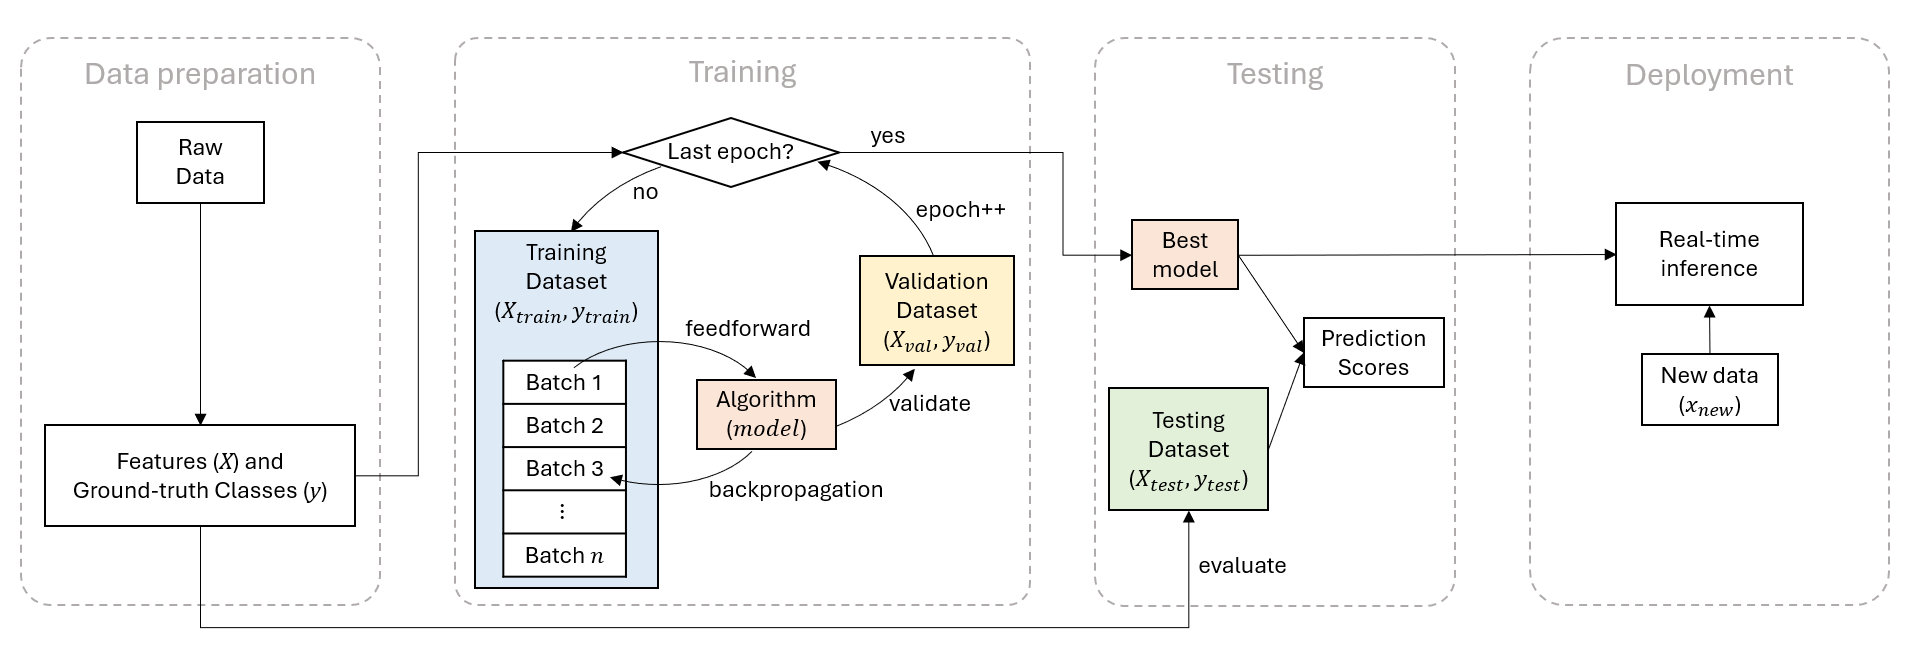

## 1. Data Preparation
We will use again the MNIST dataset as our `raw data`.





Recall that you can download the `mnist_digits.csv` from this [GDrive](https://drive.google.com/file/d/1eAmVYcpRvkYM7MXb7vTu95zQjWjS1iet/view?usp=sharing).

In [15]:
import pandas as pd

try: # if csv file is already in Colab, then load
  raw_data = pd.read_csv("C:/Users/DWIGHT LANCE JUMAOAS/don't open this/emerging_technology/emerging-technologies-main/activities/machine_learning_samples/lfw_people.csv")
  print("Loaded lfw_people.csv into a DataFrame.")
except FileNotFoundError: # otherwise, allow user to upload the CSV file
  uploaded = files.upload()
  for filename in uploaded.keys():
      raw_data = pd.read_csv(filename)
      print(f"Loaded {filename} into a DataFrame.")

Loaded lfw_people.csv into a DataFrame.


There will be no changes when preparing the dataset. So, our next move is to determine the `features` and `ground-truth classes`. Once again, we will represent the array of features as the `X` variable, while the ground-truth classes (or the targets) as the `y` variable.

In [16]:
X = raw_data.iloc[:, :-1]
y = raw_data.iloc[:, -1]

Likewise we will perform data splitting: 70% training, 15% validation, and 15% testing.


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_others, y_train, y_others = train_test_split(
    X, # features
    y, # targets
    train_size=0.7, # 70% training set
    stratify=y, # split according to even distribution of targets
    shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_others, # features
    y_others, # targets
    test_size = 0.5, # 15% = 0.5 of 30%
    stratify=y_others, # split according to even distribution of targets
    shuffle=True
)

Alright! So now, you need to remember that:


1.   `X_train` and `y_train` correspond to the features and targets in the training set.
2.   `X_val` and `y_val` correspond to the features and targets in the validation set.
3.   `X_test` and `y_test` correspond to the features and targets in the training set.



## 2. Training

In this laboratory notebook,we will utilize again the same algorithm, which is the ANN-MLP. We also retain the number of hidden layers and the number of hidden nodes. However, we introduce two new things:


1.   Epoch and batch size
2.   Categorical cross-entropy loss




In [18]:
from sklearn.linear_model import PassiveAggressiveClassifier

# Initialize model
model = PassiveAggressiveClassifier(
    max_iter=1000, 
    C=1,          
    loss="squared_hinge"  
)


Before we go for training, we need to learn first what are `epoch` and `batch size`.


*   `epoch`: refers to one complete pass through the entire training dataset.
*   `batch_size`: defines the number of samples that are used to update the model's parameters at each step during training.



In [19]:
epochs = 500
batch_size = 512

Since we will try to learn by batch size, let us create a function that create batches.

In [20]:
def get_batches(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        yield X_batch, y_batch

Also since what we want to do is a multiclass classification, we need to use the `categorical cross-entropy loss`. It is mathematically defined as:

$ Loss = - \sum^{N}_{i=1} \sum^{C}_{c=1} y_{ic} log(p_{ic})$

where,
* $C$ is the number of classes (here, is 10)
* $y_{ic}$ is the binary indicator (0 or 1) if class label $c$ is the correct classification for observation $i$
* $p_{ic}$ is the predicted probability of observation $i$ being of class $c$

But, no need to worry! Because we can call `log_loss` from scikit-learn to compute this value.

In [21]:
from sklearn.metrics import log_loss

Now, we begin the training of the model over multiple epochs with batch processing.

In [22]:
import numpy as np
import copy

history = {'train_losses': [], 'val_losses': [], 'best_model': None, 'best_epoch': 0}
classes = np.unique(y)

for epoch in range(epochs):
    first_batch = True  # reset each epoch

    # Train in mini-batches
    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
        if first_batch:
            model.partial_fit(X_batch, y_batch, classes=classes)
            first_batch = False
        else:
            model.partial_fit(X_batch, y_batch)

    # --- Training loss ---
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)
    else:
        # fallback for hinge loss: use decision_function -> softmax approximation
        decision = model.decision_function(X_train)
        exp_scores = np.exp(decision - np.max(decision, axis=1, keepdims=True))
        y_train_proba = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    y_train_proba = np.clip(y_train_proba, 1e-15, 1 - 1e-15)
    train_loss = log_loss(y_train, y_train_proba)

    # --- Validation loss ---
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val)
    else:
        decision = model.decision_function(X_val)
        exp_scores = np.exp(decision - np.max(decision, axis=1, keepdims=True))
        y_val_proba = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    y_val_proba = np.clip(y_val_proba, 1e-15, 1 - 1e-15)
    val_loss = log_loss(y_val, y_val_proba)

    print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    # Save best model (deepcopy to freeze weights)
    if (history['best_model'] is None) or (val_loss < min(history['val_losses'], default=float("inf"))):
        history['best_model'] = copy.deepcopy(model)
        history['best_epoch'] = epoch

    history['train_losses'].append(train_loss)
    history['val_losses'].append(val_loss)


Epoch 1/500: train_loss=1.4751, val_loss=1.5220
Epoch 2/500: train_loss=1.3433, val_loss=1.4320
Epoch 3/500: train_loss=1.1950, val_loss=1.3349
Epoch 4/500: train_loss=1.2881, val_loss=1.4102
Epoch 5/500: train_loss=0.9827, val_loss=1.1347
Epoch 6/500: train_loss=1.1473, val_loss=1.3205
Epoch 7/500: train_loss=0.8812, val_loss=1.0406
Epoch 8/500: train_loss=0.8156, val_loss=1.0132
Epoch 9/500: train_loss=0.9376, val_loss=1.1251
Epoch 10/500: train_loss=0.9023, val_loss=1.0902
Epoch 11/500: train_loss=0.8801, val_loss=1.1073
Epoch 12/500: train_loss=0.8814, val_loss=1.1213
Epoch 13/500: train_loss=0.8772, val_loss=1.0853
Epoch 14/500: train_loss=0.6957, val_loss=0.9099
Epoch 15/500: train_loss=0.6304, val_loss=0.8444
Epoch 16/500: train_loss=0.7388, val_loss=0.9639
Epoch 17/500: train_loss=0.5736, val_loss=0.8250
Epoch 18/500: train_loss=0.5547, val_loss=0.8046
Epoch 19/500: train_loss=0.9765, val_loss=1.1829
Epoch 20/500: train_loss=0.6242, val_loss=0.8523
Epoch 21/500: train_loss=0.68

Let us try to observe the trend of the training and validation losses. Going down together is better!

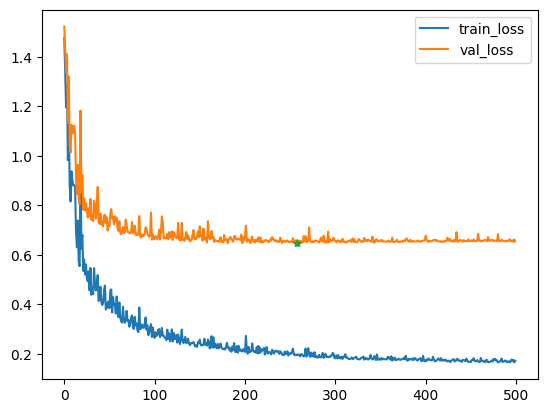

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), history['train_losses'], label='train_loss')
plt.plot(range(epochs), history['val_losses'], label='val_loss')
plt.plot(history['best_epoch'], history['val_losses'][history['best_epoch']], marker='*')
plt.legend()
plt.show()

**Warning**: The common mistake with programmers is that they forgot to save the model at the best validation loss (minimum val_loss). The `history` variable tracks the best model.

Now, let us try to validate our model using the validation set. Notice that we use the `X_val` and `y_val`.

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.50      0.60        12
     Colin Powell       0.78      0.80      0.79        35
  Donald Rumsfeld       0.69      0.50      0.58        18
    George W Bush       0.85      0.92      0.88        79
Gerhard Schroeder       0.83      0.88      0.86        17
      Hugo Chavez       0.89      0.73      0.80        11
       Tony Blair       0.70      0.76      0.73        21

         accuracy                           0.80       193
        macro avg       0.78      0.73      0.75       193
     weighted avg       0.80      0.80      0.80       193



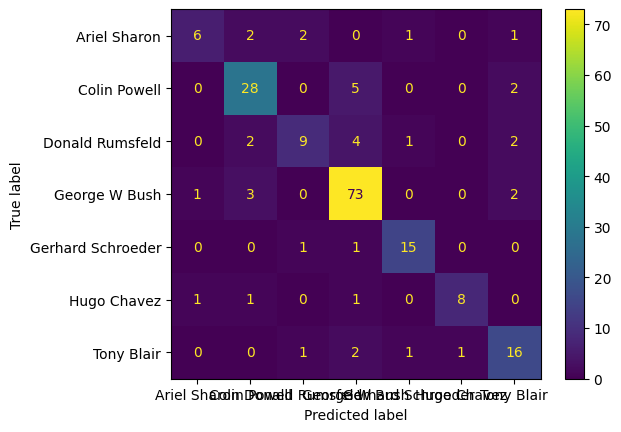

In [24]:
from sklearn import metrics

best_model = history['best_model']
y_val_pred = best_model.predict(X_val)
print(f"{metrics.classification_report(y_val, y_val_pred)}")
metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)

## 3. Testing

Let us evaluate our best model using the testing set `X_test` and `y_test`.

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.91      0.87        11
     Colin Powell       0.85      0.81      0.83        36
  Donald Rumsfeld       0.75      0.79      0.77        19
    George W Bush       0.90      0.95      0.93        80
Gerhard Schroeder       0.82      0.88      0.85        16
      Hugo Chavez       0.88      0.70      0.78        10
       Tony Blair       0.89      0.77      0.83        22

         accuracy                           0.87       194
        macro avg       0.85      0.83      0.84       194
     weighted avg       0.87      0.87      0.86       194



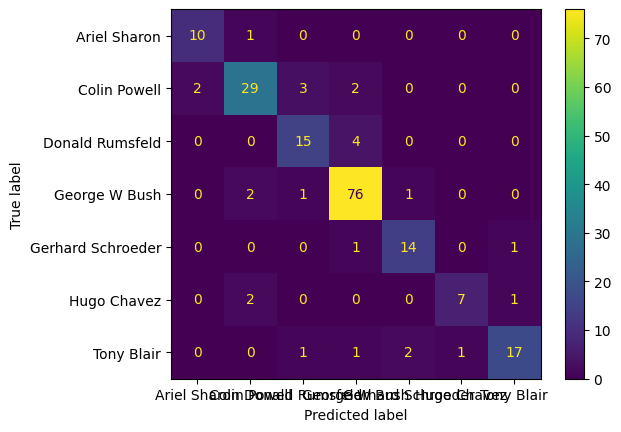

In [25]:
y_test_pred = best_model.predict(X_test)
print(f"{metrics.classification_report(y_test, y_test_pred)}")
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

Note: Do not forget to save your model offline.

In [26]:
import joblib

joblib.dump(best_model, 'mlp_model_e3.pkl')

['mlp_model_e3.pkl']

## 4. Deployment

When deploying your system, you are not required to re-run the training, but you just need to run feedforward prediction using the saved model.

In [27]:
import joblib
import numpy as np

# Load trained model
loaded_model = joblib.load('mlp_model_e3.pkl')

# New sample (8x8 = 64 features)
x_new = [
    0,  0,  0,  5,  9,  0,  0,  0,
    0,  0,  2, 14, 14, 22,  0,  0,
    0,  0,  6, 14, 11,  9,  0,  0,
    0,  3, 15,  3, 11,  5,  0,  0,
    0,  8, 11,  0, 13,  6,  2,  0,
    6, 10, 16, 16, 12, 15, 17,  0,
    0,  0,  4, 10, 15,  3,  0,  0,
    0,  0,  0, 11, 13,  2,  0,  0
]

# Convert to numpy array
x_new = np.array(x_new).reshape(1, -1)   # shape = (1, 64)

# --- Fix shape mismatch ---
# Pad with zeros to match the model's expected number of features
expected_features = loaded_model.n_features_in_
if x_new.shape[1] < expected_features:
    # Pad zeros on the right
    x_new = np.pad(x_new, ((0, 0), (0, expected_features - x_new.shape[1])), mode='constant')

elif x_new.shape[1] > expected_features:
    # Trim extra features if too many
    x_new = x_new[:, :expected_features]

# Predict
y_new_pred = loaded_model.predict(x_new)
print(f"Predicted digit = {y_new_pred[0]}")


Predicted digit = Colin Powell


c:\Users\DWIGHT LANCE JUMAOAS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PassiveAggressiveClassifier was fitted with feature names
  warnings.warn(


**Challenge**: Try to run this [Python script](https://drive.google.com/file/d/1TkXU8jfWE03bb_N2AUL5_C9Y_vM1Kj7q/view?usp=drive_link) in offline mode, not here in Google Colab. Note that the file is the Python script from Laboratory 2. However, make sure to place both Python script and trained model (`mlp_model_e3.pkl`) in the same directory. Also, change the line that loads the model, overwrite with `mlp_model_e3.pkl`.

In [28]:
# End of laboratory notebook. Nothing follows ...